<a href="https://colab.research.google.com/github/differential-machine-learning/notebooks/blob/master/Bermudan5F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential PCA and regression on the Bermudan five-factor dataset

---
Brian Huge & Antoine Savine, August 2021
---

On <b>Colab</b>, click <b>View/Expand sections</b> or press <b>ctrl+\[</b> to unhide all cells.

This notebook applies <b> Differential PCA and regression</b>, introduced in the October 2021 Risk article <b> Axes that matter: PCA with a difference</b>, and implemented in the notebooks [DifferentialPCA.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialPCA.ipynb) and [DifferentialRegression.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb), to the classic problem of the continuation value and factor dependence of a Bermudan swaption. We refer to the classic papers [Valuing American Options by Simulation: A Simple Least-Squares Approach by Longstaff and Schwartz](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=137399) and [Factor Dependence of Bermudan Swaption Prices: Fact or Fiction? by Andersen and Andreasen](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=209988) for an exposition of the problem, well-known to quantitative finance practitioners and academics. 

While the problem is well documented and understood, this notebook demonstrates the aptitude of differential PCA to find the correct answers from simulated data alone. Along the way, we will highlight some shortcomings of classic PCA for dimension reduction in finance and better appreciate the application of differential PCA to analyze the risks of Derivatives transactions and trading books, automatically, from simulated data. The methodology, here applied to a particular Bermudan option in a 5F Gaussian model, carries over to arbitrary Derivatives transactions or trading books, with arbitrary pricing models. 

Implementation code for differential PCA and regression was copied here in the interest of self-containment, although it is advised to read the notebooks [DifferentialRegression.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb) and [DifferentialPCA.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialPCA.ipynb) (preferably in this order) first. The numerical results and charts published in the Risk article were obtained with this notebook.

# Imports

In [132]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print('Running on CoLab')
else:
    colab = False
    # enable full width for wide figures
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
    display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
    print('Not running on CoLab')

if colab:
  %matplotlib inline
else:
  %matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
if colab == True: mpl.rc('animation', html='jshtml')

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline

from scipy.stats import norm # cumulative normal distribution

# enable full width for wide figures
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

# disable annoying warnings
import warnings
warnings.filterwarnings("ignore")

# constants
epsilon = 1.0e-08

Not running on CoLab


# Copy of implementation code for classic and differential PCA and regression

See [DifferentialRegression.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb) and [DifferentialPCA.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialPCA.ipynb).

In [133]:
# classic polynomial regression
def make_polynomial(degree=5):
    return make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(normalize=True))

# differential polynomial regression
class DifferentialRegression:
    
    def __init__(self, degree=5, alpha=1.0):
        self.degree = degree
        self.polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
        self.alpha = alpha
    
    def fit(self, x, y, z):     
        self.phi_ = self.polynomial_features.fit_transform(x)
        self.powers_ = self.polynomial_features.powers_
        
        self.dphi_ = self.phi_[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + epsilon)
                
        self.lamj_ = ((y ** 2).mean(axis=0) / (z ** 2).mean(axis=0)).reshape(1,1,-1)
        self.dphiw_ = self.dphi_ * self.lamj_
        
        phiTphi = np.tensordot(self.dphiw_, self.dphi_, axes=([0,2],[0,2]))
        phiTz = np.tensordot(self.dphiw_, z, axes=([0,2],[0,1])).reshape(-1,1)
        
        # note we use np.linalg.pinv (as opposed to np.linalg.inv) to perform safe (SVD) inversion, resilient to near singularities
        inv = np.linalg.pinv(self.phi_.T @ self.phi_ + self.alpha * phiTphi, hermitian=True)
        self.beta_ = (inv @ (self.phi_.T @ y + self.alpha * phiTz)).reshape(-1, 1)
        
    def predict(self, x, predict_derivs=False):
        phi = self.polynomial_features.transform(x)
        y_pred = phi @ self.beta_
        
        if predict_derivs:
            dphi = phi[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + eps)
            z_pred = np.tensordot(dphi, self.beta_, (1, 0)).reshape(dphi.shape[0], -1)
            return y_pred, z_pred
        else:
            return y_pred
        
# classic PCA 
from sklearn.decomposition import PCA

# differential PCA
class DiffPCA:
    
    def __init__(self, n_components=None, central=False):
        """
        The API is consistent with sklearn.decomposition.PCA 
        (see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
        
        n_components = number of components to keep. If n_components is None all components are kept:
        n_components == n_features
        
        If 0 < n_components < 1, select the number of components such that 
        the amount of 'variance' (squared magnitude) that needs to be explained is greater than the percentage specified by n_components
        
        Default = squared error magnitude (epsilon*total_variance in the article) of 10^(-8), i.e. error norm is 0.01% of total norm
                        
        central = specific to differential PCA, standard scikit-learn PCA is always central. By contrast, 
        differential PCA is noncentral by default, see article
        """
        
        self.n_components = n_components
        self.central = central
        
    def fit(self, X, Z, y=None): # note y is ignored, just like in scikit-learn PCA
        """
        X: input data
        Z: differential data = dy/dZ, see article
        (y: labels)
        """
        
        # data shape
        self.n_samples_, self.n_features_ = X.shape
        
        # central?
        self.mean_ = Z.mean(axis=0) # average differentials
            
        # compute covariance matrix of differentials
        z = Z - self.mean_ if self.central else Z
        self.cov_ = z.T @ z / self.n_samples_
        
        # eigenvalue decomposition
        d, P = np.linalg.eigh(self.cov_)
                
        # reverse order so largest eigenvalues come first
        d = d[::-1]
        P = P[:, ::-1]
        
        sumd = np.cumsum(d)
        total_variance = sumd[-1]

        # find the number of principal components
        if self.n_components is not None: 
            # n_components is larger than 1 = number of components
            if self.n_components >= 1:
                self.n_components_ = self.n_components
            # n_components is smaller than 1 = square magnitude explained
            else:
                sumd /= total_variance
                self.n_components_ = np.searchsorted(sumd, self.n_components) + 1
            
        else:
            self.n_components_ = min(self.n_samples_, self.n_features_)
            
        explained = sumd[self.n_components_-1]
        unexplained = total_variance - explained

        # filter irrelevant components
        d = d[:self.n_components_]
        P = P[:, :self.n_components_]
            
        # results, attributes as in sklearn.decomposition.PCA
        self.components_ = P.T
        self.explained_variance_ = d
        self.explained_variance_ratio_ = d / total_variance
        self.singular_values_ = np.sqrt(d)
        self.noise_variance_ = unexplained
        
    def transform(self, X, Z=None): 
        
        # transformed dataset
        L = X @ self.components_.T
        
        if Z is None:
            return L
        
        else:
            # transformed derivatives
            S = Z @ self.components_.T
            return L, S
        
    def fit_transform(self, X, Z, y=None):
        self.fit(X, Z, y)
        return self.transform(X, Z)
    
    def inverse_transform(self, L, S=None):
        
        # L to X
        X = L @ self.components_
        
        if S is None:
            return X
        
        else:
            # S to Z
            Z = S @ self.components_
            return X, Z

# The Bermudan 5F dataset

The dataset was produced by Monte-Carlo simulation in a five-factor Gaussian Cheyette model (a.k.a. 5F Hull & White, also called 5F Linear Gauss Markov model or simply 5F-LGM) calibrated to August 2021 EUR market data in a professional Derivatives system written in C++ and instrumented with [algorithmic adjoint differentiation (AAD)](https://sites.google.com/view/antoinesavine-aad), hence the availability of differential labels.

Multi-factor Cheyette (MFC) models, of which Gaussian models are the simplest variants, are heavily documented in literature, e.g. in [Andersen and Piterbarg's classic textbooks](http://andersen-piterbarg-book.com/), Andreasen's 2005 Risk paper [Back to the Future](https://www.risk.net/derivatives/interest-rate-derivatives/1500253/back-future), or [our presentation](https://medium.com/@antoine_savine/introduction-to-interest-rate-models-22f9abe5e2b8). 

The financial instrument is an idealized fifteen-year EUR payer swap, twice early callable, Bermudan style, in two and five years. 

Let us first load the dataset.

In [134]:
# read dataset

x_train = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_x_train.csv", header=None).to_numpy() 
y_train = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_y_train.csv", header=None).to_numpy() 
z_train = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_dydx_train.csv", header=None).to_numpy() 

x_test = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_x_test.csv", header=None).to_numpy() 
y_test = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_y_test.csv", header=None).to_numpy() 

print(x_train.shape, y_train.shape, z_train.shape, x_test.shape, y_test.shape)

(8192, 5) (8192, 1) (8192, 5) (128, 5) (128, 1)


We see that the training set consists of 8,192 independent examples in dimension 5, and the test set collects another 128 independent examples. Each example has inputs $X \in \mathbb{R}^5$ and label $y \in \mathbb{R}$. Differential labels $Z=\partial y / \partial X \in \mathbb{R}^5$ are also available in the training set. 

Let us first make sense of this dataset. Pick three random training examples. 

In [135]:
m, n = x_train.shape
num_examples = 3
indices = np.random.choice(m, size=num_examples, replace=False)
x, y, z = x_train[indices], y_train[indices], z_train[indices]
with np.printoptions(precision=4):
    for i in range(num_examples):  print('example', i, ':', 'x = ', x[i], ' | y = ', y[i], ' | z = ', z[i])

example 0 : x =  [-0.0026  0.1158 -0.3132  0.3085 -0.1057]  | y =  [15.7823]  | z =  [990.1039 539.7548 268.0686 121.1103  43.829 ]
example 1 : x =  [ 0.0259 -0.0647  0.2088 -0.2662  0.1056]  | y =  [19.6668]  | z =  [943.0874 512.8578 253.5124 113.4214  39.9579]
example 2 : x =  [ 0.002   0.0846 -0.263   0.2729 -0.1075]  | y =  [0.1519]  | z =  [1193.6258  653.3989  327.9422  152.0706   59.2294]


What do these numbers mean exactly?

The inputs $X=\left(X_1, X_2, X_3, X_4, X_5\right)$ encode the state of the yield curve in two years, on the first early exercise date. In the 5F Gaussian model, the yield curve in two years, expressed in terms of instantaneous forward rates (IFR) of maturities $T$, is given by:

$$
    f\left(T\right) = f\left(0, T\right) + g\left(T\right) + \sum_{i=1}^5 X_i e^{-\kappa_i T}
$$

where $f\left(0, T\right)$ is the initial yield curve today, $g\left(T\right)$ is a deterministic convexity adjustment so the model prevents convexity arbitrage (it has a closed-form expression in the Gaussian case, not important for our purpose) and the vector $\kappa=\left(\kappa_1, \kappa_2, \kappa_3, \kappa_4, \kappa_5\right)$ of random deformations exponential slopes was set to $\left(0, 0.1, 0.25, 0.5, 1\right)$ for the purpose of this exercise. Since $f\left(0, T\right) + g\left(T\right)$ is deterministic, it is not part of the state of the curve, which is fully determined by the state $X \in \mathbb{R}^5$, measured on the first call date. $X$ is a Gaussian vector, which covariance was calibrated to European swaption data and historical interest-rate correlation. 

The function below translates a state $X$ into a forward curve deformation $T \to \sum_{i=1}^5 X_i e^{-\kappa_i T}$.

In [136]:
ks = np.array([0.0, 0.1, 0.25, 0.5, 1.0]).reshape(1, -1)

def forward_curve(X, ks=ks):
    
    def f(T):
        return np.dot(np.exp(-ks * T), X)
    
    return f

We can now visualize the forward curve deformations over two years in our three independent scenarios.

<IPython.core.display.Javascript object>


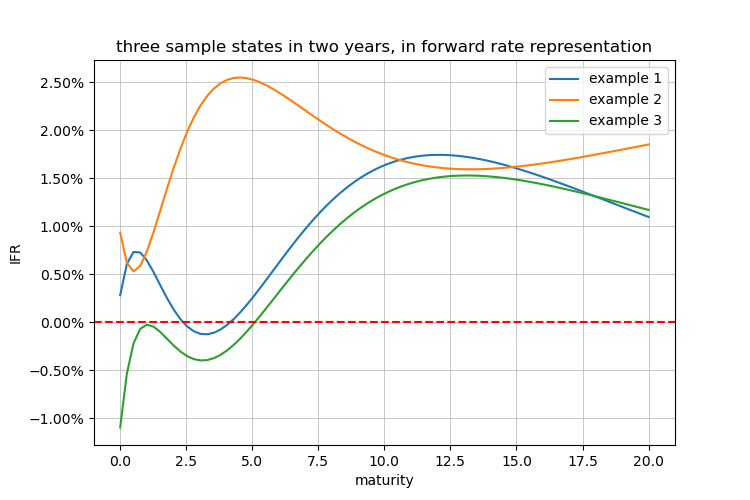

In [137]:
# every 3m up to 20y
ts = np.linspace(0, 20, 80).reshape(-1, 1)

def draw_fwd_curves(ax, Xs, labels=None, title=None, colors=None, widths=None, percent=True, ylabel="IFR", ts=ts, ks=ks):

    for i, X in enumerate(Xs):
        f = forward_curve(X)
        fwds = f(ts)
        if fwds.sum() < 0: fwds *= -1 # flip if negative for a clearer picture
        ax.plot(ts, fwds, label=labels[i] if labels else None, color=colors[i] if colors else None, lw=widths[i] if widths else None)
    ax.legend()
    ax.axhline(linestyle='--', color='r')
    ax.set_xlabel('maturity')
    ax.set_ylabel(ylabel)
    if percent: ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax.set_title(title)
    ax.grid(lw=.5)

    
plt.figure(figsize=(7.5, 5))
draw_fwd_curves(plt.gca(), x, ['example %d' % (i+1) for i in range(num_examples)], "three sample states in two years, in forward rate representation")
_ = plt.show()

Each example therefore corresponds to an independent deformation of the forward curve between now and the first call date in two years, drawn from a risk-neutral Gaussian distribution with calibrated covariance, and parcimoniously encoded in a Gaussian vector $X$ of dimension five. 

Next, we examine the labels $y$. The yield curve in the first scenario, displayed in blue on the figure above, is labeled by the real number:

In [138]:
print(y[0])

[15.78]


$y\left[i\right]$ is the continuation payoff in scenario $i$, simulated by Monte-Carlo over the lifetime of the underlying swap (fifteen years), with initial condition in two years given by $x\left[i\right]$. Assuming the early call is not exercised in two years, the holder remains in a payer swap for another thirteen years, with another early exercise opportunity, three years later, five years from now. This second call will be exercised if and only if the present value of the swap with remaining maturity ten years, measured on the second call date (in three years time, five years from now), is negative. Otherwise, the swap will proceed for another ten years. The continuation payoff is therefore equal to: 

$$
y = \left(\text{sum of coupons paid between 2y and 5y, discounted to 2y}\right) + 1_{\left\{swap\_pv\left(5y, 15y\right) > 0\right\}} \left(\text{sum of coupons paid after 5y, discounted to 2y}\right)
$$

the present value in 2y of the coupons over the next 3y prior to the second call date, plus the remaining coupons over the next 10y, if positive as measured on the second call date in 3y time (5y from now), discounted back to the first call date, two years from now. The continuation payoff depends on the state of the yield curve on the second call date (five years from now, three years from the first call date) for the second early exercise, and up to 15y from now for the fixing of the floating coupons and discount factors. The curve is simulated with one Monte-Carlo path with initial state in two years encoded in $X$. The label $y$ is equal to the continuation payoff, for a notional of 100, along the simulated path. Crucially, the continuation <b> value </b> is the conditional expectation $E\left[y|X\right]$ and the holder will exercice the first call if and only if the continuation value is negative. Note that the continuation value is a function of $X$, measured in two years on the first call date, whereas the payoff $y$ is measureable only in 15y. The second exercise, in particular, is only decided three years later.

The differential labels $Z$ encode the <b> pathwise derivatives</b>, the gradient of the payoff $y$ wrt the initial state encoded in $X$. 

In [139]:
print(z[0])

[990.1  539.75 268.07 121.11  43.83]


The pathwise differential $Z\left[i, j\right]$  tells how much $y\left[i\right]$ reacts to an infinitesimal bump of $X\left[i,j\right]$, everything else being unchanged, in particular, the random numbers for the simulation of the paths.

The pathwise differentials $Z$ were computed with Automatic Adjoint Differentiation or AAD, for a very small computation cost, and with analytic accuracy, see the [founding paper for AAD in finance](https://www.risk.net/derivatives/interest-rate-derivatives/1500261/smoking-adjoints-fast-monte-carlo-greeks), our [15-minutes presentation](https://towardsdatascience.com/automatic-differentiation-15min-video-tutorial-with-application-in-machine-learning-and-finance-333e18c0ecbb) or read the full story in the reference book [Modern Computational Finance](https://www.amazon.co.uk/Modern-Computational-Finance-Parallel-Simulations/dp/1119539455). It is those differential labels that enable powerful differential ML algorithms, as we are going to see.  

The test set consists of 128 independent examples where $X \in \mathbb{R}^5$ encodes the state of the curve in two years, just like training data, and labels $y$ provide the ground truth continuation <b> values</b> in these states (<b>not </b> payoffs), computed with nested Monte-Carlo (although closed-form formulas are available in this simple example, but not in most practical cases). Test differentials are not provided.

Finally, we load another dataset for the <b> European </b> 5y10y swaption. The training and test states $X$ in two years are the same, but the training and test labels now contain the payoffs and values in two years of the European option with expiry three years later into a ten years payer swap, excluding the coupons between two and five years. We will mainly work with the Bermudan dataset, but we will use the European dataset to highlight that differential PCA yields different results for different products and correctly identifies factor dependence in different cases, contrarily to classic PCA, which disregards labels and therefore yields the same results irrespective of the financial product. 

In [140]:
y_train_euro = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/euro_5f_y_train.csv", header=None).to_numpy() 
z_train_euro = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/euro_5f_dydx_train.csv", header=None).to_numpy()
y_test_euro = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/euro_5f_y_test.csv", header=None).to_numpy() 

# Learning the continuation value by polynomial regression

The continuation value $v\left(X\right) = E\left[y|X\right]$ can be correctly learned from the dataset by Machine Learning (ML) models with the Universal Approximation property, such as basis regression or artificial neural networks (ANN), by minimization of the mean squared error (MSE). This result was demonstrated in the original Least Square Monte-Carlo paper in the context of basis regression, and it carries over to ANN and other universal approximators, see our October 2020 Risk paper [Differential Machine Learning: the Shape of Things to Come](https://www.risk.net/cutting-edge/banking/7688441/differential-machine-learning-the-shape-of-things-to-come) for a sketch of proof.

Although ANN perform better and are resilient in high dimension (see [DifferentialRegression.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb) for a demonstration), here, we demonstrate basis regression. Regression is directly applicable for the Bermudan dataset, since its dimension is only $5$. The vast majority of problems in finance, however, stand in (much) higher dimension, where regression is not applicable without drastic dimension reduction.

In the cell below, we perform classic polynomial regression of degree $5$ over the raw training data, and measure the quality of the learned continuation value function by comparison with the correct values of the test set.

<IPython.core.display.Javascript object>


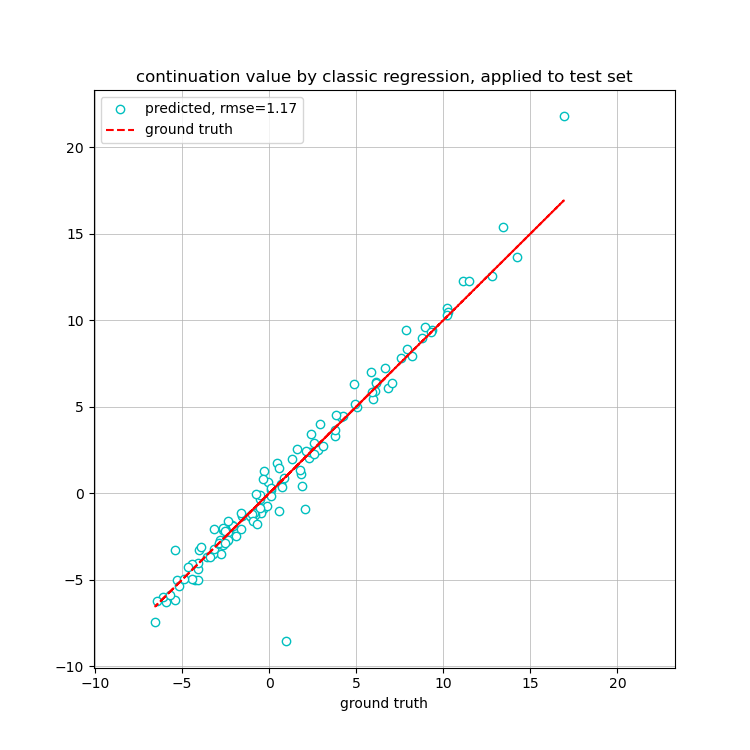

In [141]:
classic_reg = make_polynomial()
classic_reg.fit(x_train, y_train)
pred = classic_reg.predict(x_test)
correct = y_test

def draw_test_results(ax, correct, preds, labels=None, title=None, colors=None):
    
    for i, pred in enumerate(preds):
        
        errors = pred - correct
        rmse = np.sqrt(np.square(errors).mean())

        ax.plot(correct, pred, ls="None", marker='o', color=colors[i] if colors else 'c', markerfacecolor="white", label="predicted"+(" by " + labels[i] if labels else '')+", rmse=%.2f" % rmse)
    
    ax.plot(correct, correct, 'r--', label="ground truth")
    ax.set_xlabel('ground truth')
    ax.set_title(title)
    ax.set_xlim(ax.get_ylim())
    ax.legend()
    ax.grid(lw=0.5)
    
plt.figure(figsize=(7.5,7.5))
draw_test_results(plt.gca(), correct, [pred], title="continuation value by classic regression, applied to test set")
_ = plt.show()

Note the poor performance, with a standard error of 1.17 in price (around 10bp per annum). 8,192 training examples is not enough to learn an accurate value function by classic regression. We can do a lot better with differential regression, leveraging the availability of differential training labels $Z$, as explained in [DifferentialRegression.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb). 

Note that we can do even much better with the differential neural networks introduced in our October 2020 paper and demonstrated in [DifferentialMLTF2.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialMLTF2.ipynb), although we stick with differential regression here.

<IPython.core.display.Javascript object>


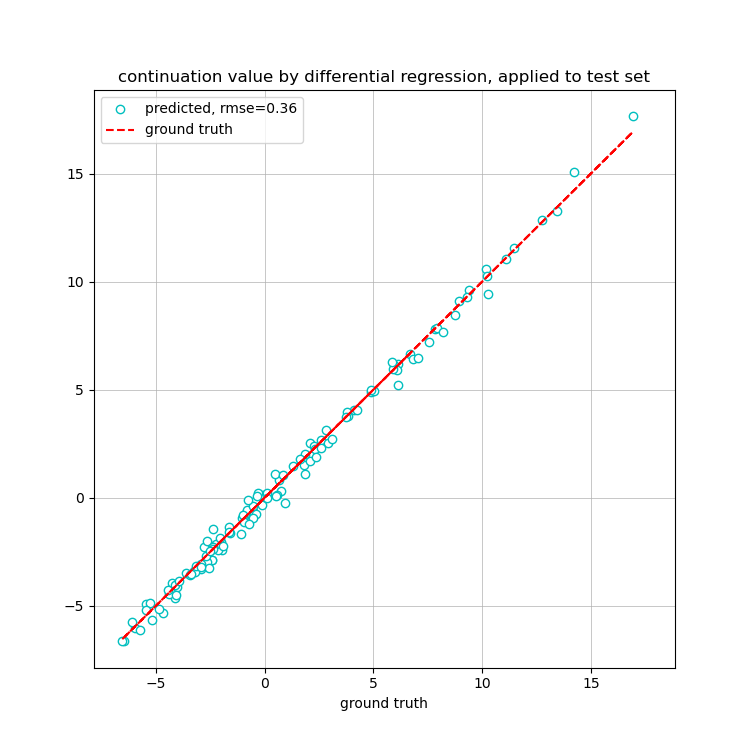

In [142]:
diff_reg = DifferentialRegression()
diff_reg.fit(x_train, y_train, z_train)
pred = diff_reg.predict(x_test)

plt.figure(figsize=(7.5,7.5))
draw_test_results(plt.gca(), correct, [pred], title="continuation value by differential regression, applied to test set")
_ = plt.show()

The standard error of 36 basis points in price translates to roughly 3bp per annum on the Bermudan swap with thirteen years residual maturity, which is decent for most applications. The error may be reduced to an arbitrary low value by increasing the size of the dataset and the degree of the polynomial regression (or with a differential neural network). 

The rest of the notebook focuses on dimension reduction. Although a decent continuation value function is learned by differential regression in this simple example, this cannot be generalized to more exotic Derivatives or trading books, where dimension routinely stands in the hundreds. Besides, we will see that, even in this simple context, continuation value is learned much faster and more accurately in appropriately reduced dimension. Finally, dimension reduction provides invaluable insights into the factor dependence and risk analysis of the Bermudan option (or other exotic Derivatives or trading books with different datasets).

# Dimension reduction with classic PCA

That a correct value could be learned from raw data confirmed that $X \in \mathbb{R}^5$ is indeed the Markov state, and that it contains all relevant information for the determination of the continuation value. The objective now is to reduce dimensionality, i.e. transform input data into lower-dimensional $L=f\left(X\right) \in \mathbb{R}^p$ with $p<5$ <b> without truncating meaningful information for the Bermudan option </b>.

Let us start with classic PCA:

In [144]:
classic_pca = PCA()
classic_pca.fit(x_train)

PCA()

Visualize how much variance is explained by the five components:

<IPython.core.display.Javascript object>


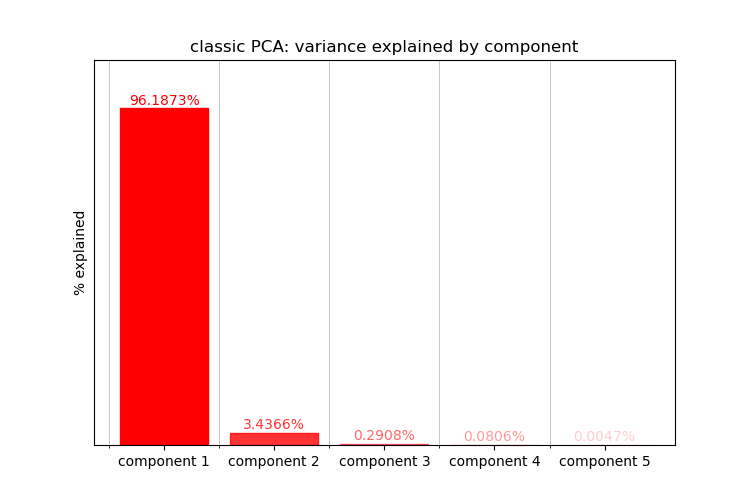

In [145]:
def draw_explained_variance(ax, pca, title):

    xaxis = np.arange(1, pca.n_components_ + 1)
    
    bars = ax.bar(xaxis, pca.explained_variance_ratio_)

    rgba_colors = np.zeros((pca.n_components_,4))
    rgba_colors[:,0] = 1.0
    rgba_colors[:,3] = [1-0.2*i for i in range(pca.n_components_)]
    
    for i, value in enumerate(pca.explained_variance_ratio_):
        ax.text(i+1, value+0.01, "{:.4%}".format(value), ha='center', color='r', alpha=1-0.2*i)
        bars[i].set_color(rgba_colors[i])
        
    ax.set_xticklabels('component %d' % i for i in range(pca.n_components_ + 1))
    ax.set_ylabel('% explained')
    ax.set_yticks([])
    ax.set_ylim([0,1.1])
    ax.set_title(title)
    ax.set_xticks(xaxis-0.5, minor=True)
    ax.grid(lw=.5, which='minor')
    
plt.figure(figsize=(7.5,5))
draw_explained_variance(plt.gca(), classic_pca, "classic PCA: variance explained by component")
_ = plt.show()

The two principal components explain 99.62% of the variance of the input data. The variation of $X$ on the three remaining dimensions is largely negligible and apparently safe to truncate. In particular, the 5th component explains less that half a basis point of the total variance. 

Let us reduce dimension to 2 by truncation of components 3, 4 and 5:

In [146]:
dim = 2

pca = PCA(dim)
x_reduced = pca.fit_transform(x_train)
z_reduced = pca.transform(z_train) # z_reduced = d y / d x_reduced
test_reduced = pca.transform(x_test)
print(x_reduced.shape, z_reduced.shape)

(8192, 2) (8192, 2)


Perform regression on the reduced data, and verify the quality of the learned continuation value by comparison with the test set. 

<IPython.core.display.Javascript object>


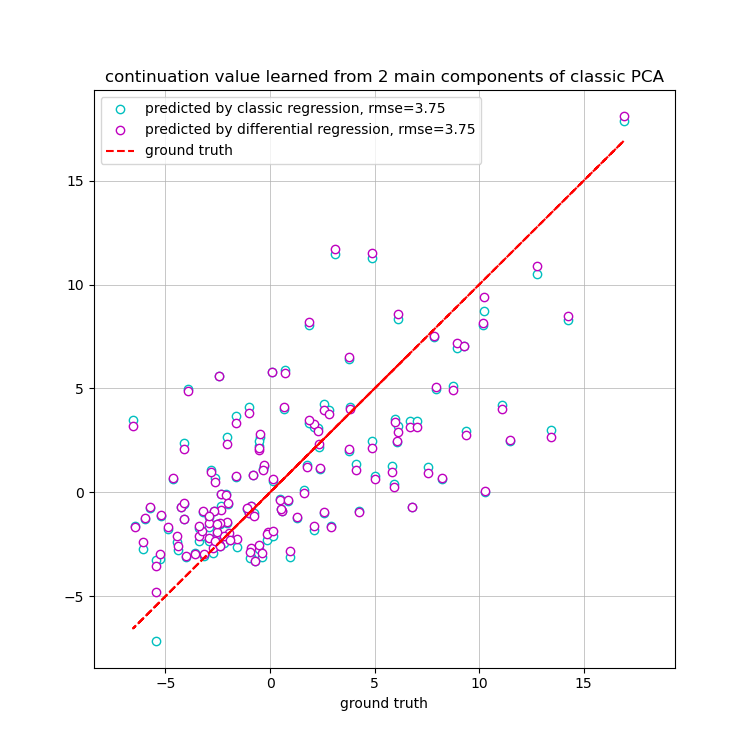

In [147]:
classic_reg.fit(x_reduced, y_train)
classic_pred = classic_reg.predict(test_reduced)

diff_reg.fit(x_reduced, y_train, z_reduced)
diff_pred = diff_reg.predict(test_reduced)

plt.figure(figsize=(7.5,7.5))
draw_test_results(plt.gca(), correct, [classic_pred, diff_pred], title="continuation value learned from 2 main components of classic PCA", 
                  colors=['c', 'm'], 
                  labels=['classic regression', 'differential regression'])
_ = plt.show()

Both classic and differential regression fail to correctly learn the continuation value from the reduced data, indicating that information meaningful for the Bermudan instrument was deleted by truncation of the (apparently insignifcant) components 3, 4 and 5. Despite insignificant variation, it appears that those components encoded important information, without which the continuation value of the Bermudan option may no longer be correctly learned. 

Furthermore, the problem persists with much more conservative truncation to dimension 3 and even 4! It looks like any kind of dimension reduction performed by classic PCA, even by only one dimension, irreparably removes information significant for the Bermudan option, as we verify below.

<IPython.core.display.Javascript object>


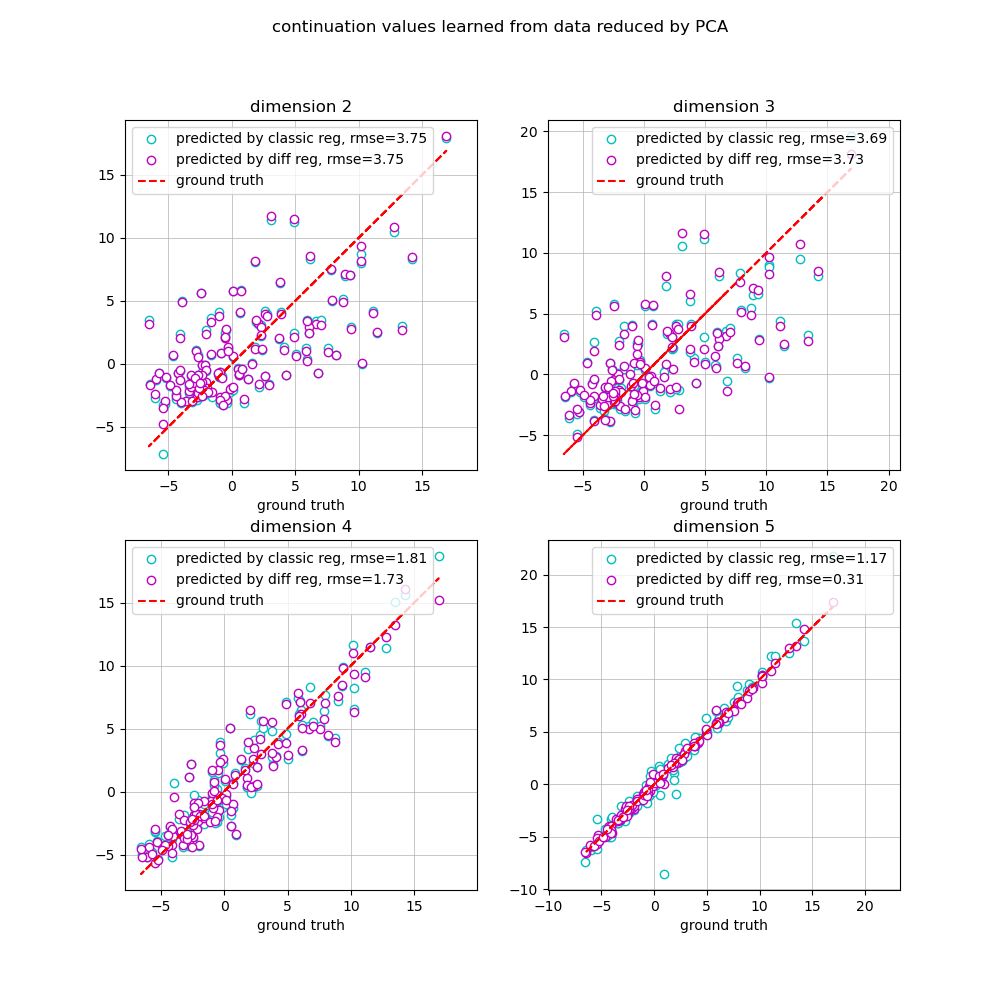

In [148]:
fig, axs = plt.subplots(2, 2, squeeze=False)
fig.set_size_inches(10, 10)

for dim, ax in enumerate(axs.flatten(), 2):
        
    pca = PCA(dim)
    x_reduced = pca.fit_transform(x_train)
    z_reduced = pca.transform(z_train) # z_reduced = d y / d x_reduced
    test_reduced = pca.transform(x_test)

    classic_reg.fit(x_reduced, y_train)
    classic_pred = classic_reg.predict(test_reduced)

    diff_reg.fit(x_reduced, y_train, z_reduced)
    diff_pred = diff_reg.predict(test_reduced)

    draw_test_results(ax, correct, [classic_pred, diff_pred], title="dimension %d" % dim, 
                  colors=['c', 'm'], 
                  labels=['classic reg', 'diff reg'])

fig.suptitle('continuation values learned from data reduced by PCA')
_ = fig.show()

On a side note, the ML literature often recommends normalizing data $X$, by subtracting means and scaling columns by standard deviation. 

It is also our experience that PCA performs more reliably on normalized data. In the context of a differential PCA, normalizing data is especially recommended. Risk sensitivities wrt normalized data are consistently expressed in units of dollars per standard deviation, and they may be reliably aggreagated and compared. Raw data, on the other hand, may be expressed in different currencies for stock data or in percentage for rate data, so it may be perilous to manipulate different sensitivities together, akin to juggling with apples and melons. 

We are not normalizing data in this notebook to keep things as simple as possible, but we always normalize input data $X$ in production. 

This being said, normalization does not save classic PCA, or or even improve things in a significant manner, as verified below. 

<IPython.core.display.Javascript object>


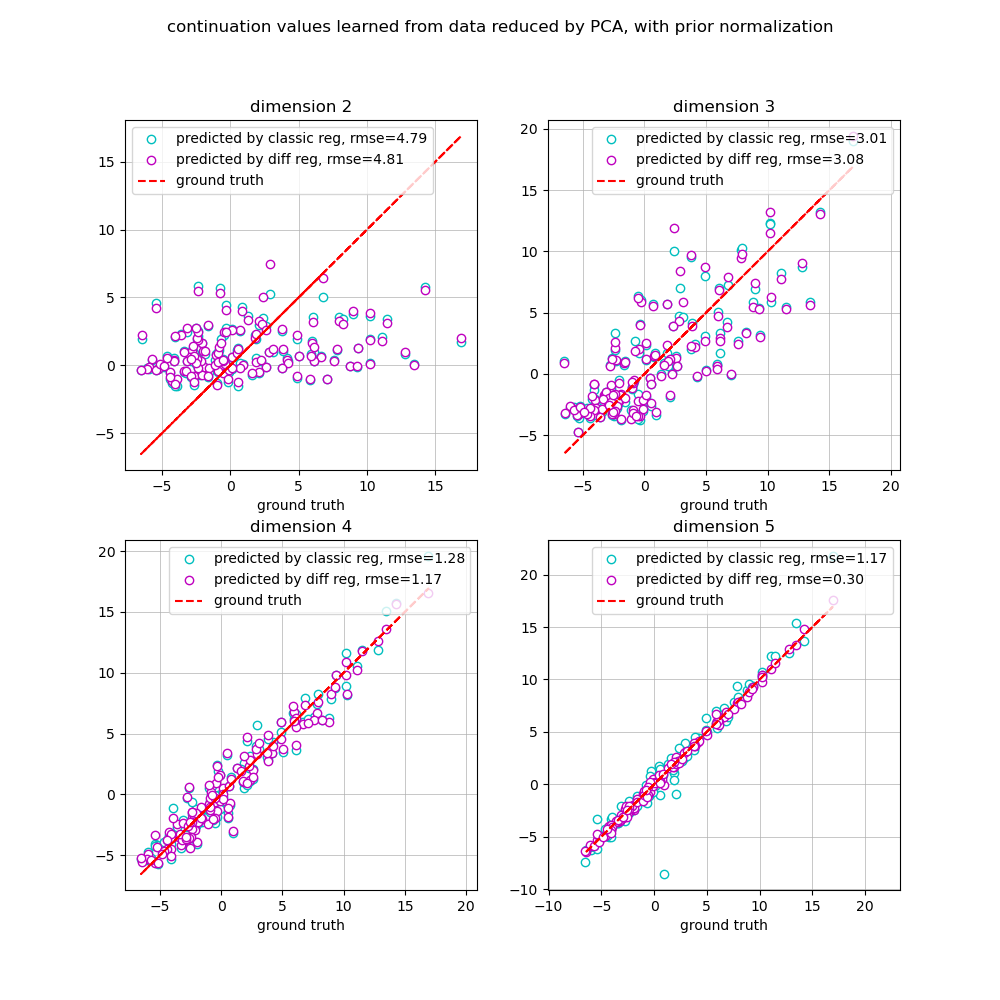

In [149]:
# normalize
mean, std = x_train.mean(axis=0), x_train.std(axis=0)
x_norm = (x_train - mean) / std
# don't forget to normalize differentials accordingly
z_norm = z_train * std
# now sensitivies are all expressed in eur/std

# normalize test set
x_test_norm = (x_test - mean) / std

# repeat
fig, axs = plt.subplots(2, 2, squeeze=False)
fig.set_size_inches(10, 10)

for dim, ax in enumerate(axs.flatten(), 2):
        
    pca = PCA(dim)
    x_reduced = pca.fit_transform(x_norm)
    z_reduced = pca.transform(z_norm) # z_reduced = d y / d x_reduced
    test_reduced = pca.transform(x_test_norm)

    classic_reg.fit(x_reduced, y_train)
    classic_pred = classic_reg.predict(test_reduced)

    diff_reg.fit(x_reduced, y_train, z_reduced)
    diff_pred = diff_reg.predict(test_reduced)

    draw_test_results(ax, correct, [classic_pred, diff_pred], title="dimension %d" % dim, 
                  colors=['c', 'm'], 
                  labels=['classic reg', 'diff reg'])

fig.suptitle('continuation values learned from data reduced by PCA, with prior normalization')
_ = fig.show()

Normalization (slightly) improves things in dimension 3 and 4, but it makes them worse in dimension 2. Normalization is not the solution. The problem with classic PCA is deeper than that.

It is important at this stage to understand exactly why PCA manifestly cannot safely reduce the dimension of the Bermudan dataset, despite only truncating coordinates of insignificant variation. Let us first inspect the components of the PCA, scaled by root eigenvalue, so that state coordinates in the scaled component basis are independent, standard Gaussians. 

<IPython.core.display.Javascript object>


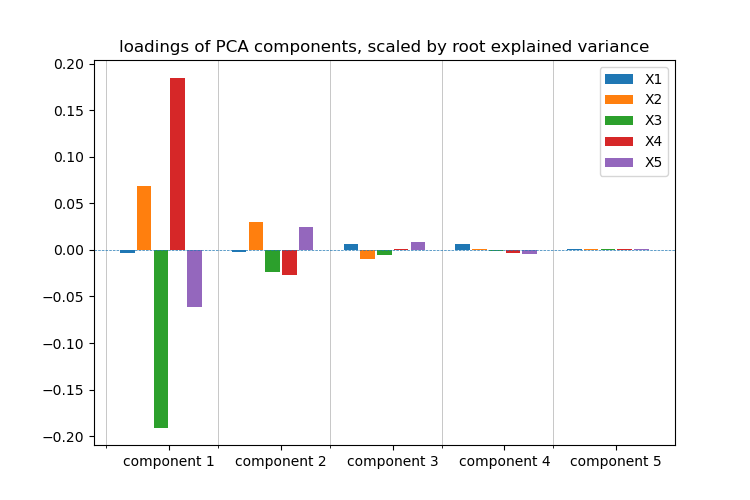

In [150]:
pca = PCA()
pca.fit(x_train)
scaled_components = pca.components_ * np.sqrt(pca.explained_variance_).reshape(-1, 1)

# plot the loadings of the scaled components in X1, X2, X3, X4 and X5
plt.figure(figsize=(7.5,5))
xaxis = np.arange(1, 6)
for i, component in enumerate(scaled_components.T):
    plt.bar(xaxis+0.15*i, component, label='X%d' % (i+1), width=0.13, align='center')
plt.xticks(xaxis+0.375, ['component %d' % (i+1) for i in range(scaled_components.shape[0])])
plt.legend()
plt.gca().set_xticks(xaxis-0.1875, minor=True)
plt.grid(lw=.5, which='minor')
plt.axhline(linestyle='--', lw=0.5)
plt.title('loadings of PCA components, scaled by root explained variance')
_ = plt.show()

This chart above shows the $X_1, X_2, X_3, X_4$ and $X_5$ loadings of the five scaled components. From this point of view, at least the 5th component looks definitely insignificant: it has near zero loadings in all $X$s. Yet, we know that it still carries critical information for the deterimnation of the continuation value. 

How? First, observe that the loadings of the 5th component are small but all positive, by contrast with components 1 through 4, which loadings are much more singificant, but change sign across $X$s. We can see that, although the squared norm of the scaled components (i.e. sum of squared loadings i.e. explained variance) is mostly concentrated on the first components, the sum of the loadings is largest on the 5th component: 



True


<IPython.core.display.Javascript object>


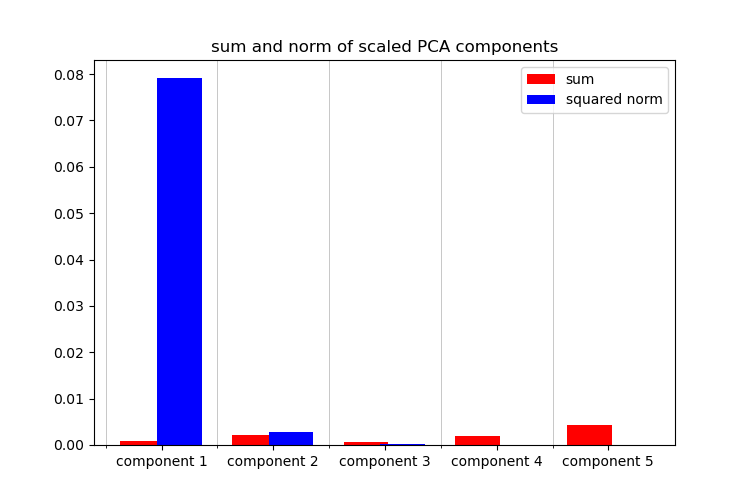

In [151]:
sums = np.abs(scaled_components.sum(axis=1))
norms = np.sqrt((scaled_components**2).sum(axis=1))

# verify that sum of squares is explained variance
print(np.allclose(norms, np.sqrt(pca.explained_variance_)))

# plot
plt.figure(figsize=(7.5, 5))
xaxis = np.arange(1, 6)
plt.bar(xaxis+0.33, sums, label='sum', width=0.4, align='center', color='r')
plt.bar(xaxis+0.66, norms**2, label='squared norm', width=0.4, align='center', color='b')
plt.xticks(xaxis+0.5, ['component %d' % (i+1) for i in range(scaled_components.shape[0])])
plt.gca().set_xticks(xaxis, minor=True)
plt.grid(lw=.5, which='minor')
plt.axhline(linestyle='--', lw=0.5)
plt.title('sum and norm of scaled PCA components')
plt.legend()

Why does this matter? Recall the formula for the deformation of the forward curve: $h\left(T\right) = f\left(T\right) - f\left(0, T\right) - g\left(T\right) = \sum_{i=1}^5 X_i e^{-\kappa_i T}$. It follows that the variation of the short rate $h\left(0\right) = \sum_{i=1}^5 X_i$ simply corresponds to the sum of the $X$s. 

The sum of the loadings, rather than the norm, is what determines the variation of the short rate. The 5th component is where the sum of the loadings is largest. Therefore, the 5th component is the main driver of the short end of the curve. This is why it cannot be truncated without removal of critical information about the state of the curve, which, in turn, determines the continuation value. The 5th component is therefore meaningful, despite its negiligible variation. Variation is simply not the correct criterion for dimension reduction.

To see this more clearly, let us examine those same scaled components, this time in terms of forward rates rather than $X$s:

<IPython.core.display.Javascript object>


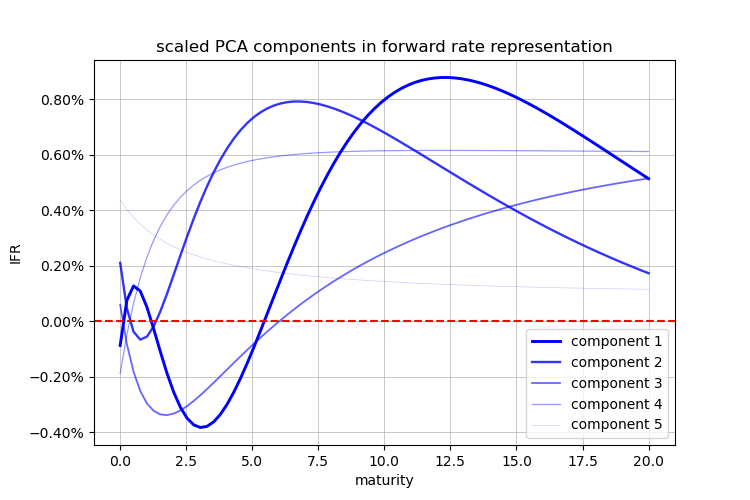

In [152]:
plt.figure(figsize=(7.5, 5))
n = scaled_components.shape[0]
draw_fwd_curves(plt.gca(), scaled_components, ['component %d' % (i+1) for i in range(n)], 
                "scaled PCA components in forward rate representation",
                colors=[[0,0,1,1-0.2*i] for i in range(n)],
                widths=[2-0.4*i+0.1 for i in range(n)])
_ = plt.show()

This picture tells a very different story. Here, all the components appear to encode significant variations of the yield curve, in particular, the 5th component clearly appears as the main driver of the short end. 

We now understand why PCA could not perform a safe dimension reduction. Insignificant variation in $X$ space translates into significant variation in forward rate space, and (forward) rates, not $X$s, is what ultimately matters for the continuation value of the Bermudan option. 

This example illustrates that PCA is unsafe and should never be applied in a pricing or risk context. Its performance heavily depends on the choice of representation. We encoded the state of the curve in terms of $X$s, but had we equivalently encoded it in terms of forward rates of five different maturities, PCA could have reduced dimension correctly. PCA only works as intended when the choice of representation is appropriate for a given problem. Because PCA is unsupervised, it doesn't know anything about the problem and it cannot infer the correct representation by itself. In other words, to safely apply PCA, one must correctly guess the correct result beforehand!

# Dimension reduction with differential PCA

Differential PCA does not have this problem. Differential PCA truncates coordinates according to the magnitude of directional gradients (which in our 2021 Risk article we named <i> relevance</i>), and gradients automatically scale with different representations in accordance with the chain rule for derivatives. One doesn't have to guess the correct representation to apply differential PCA, the algorithm finds the correct representation from data, performing safe dimension reduction along the way.

Thge application of classic PCA to the Bermudan dataset clearly highlighted the dangers of the procedure. By contrast, we formally demonstrated the safety of differential PCA in the 2021 Risk article. Here, we illustrate the result in the context of the Bermudan dataset, by repeating the steps previously performed with classic PCA, this time with differential PCA: fit on training data (including the critical differential data $Z$) and draw the bar chart of explained 'variance' (with differential PCA, this is actually explained 'relevance', i.e. magnitude of directional gradients):

<IPython.core.display.Javascript object>


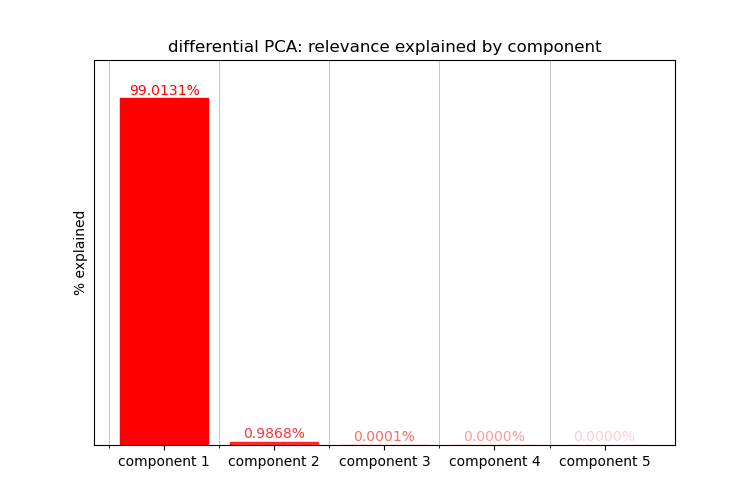

In [153]:
# fit
dpca = DiffPCA()
dpca.fit(x_train, z_train)

# plot
plt.figure(figsize=(7.5,5))
draw_explained_variance(plt.gca(), dpca, "differential PCA: relevance explained by component")
_ = plt.show()

Differential PCA tells us that the two principal (differential) components account for 99.9999% of the total gradient magnitude, and that it is completely safe to reduce dimension to 2. Let us verify that this is indeed correct by learning continuation value from reduced data and compare predictions with ground truth on the independent test set:

(8192, 2) (8192, 2)


<IPython.core.display.Javascript object>


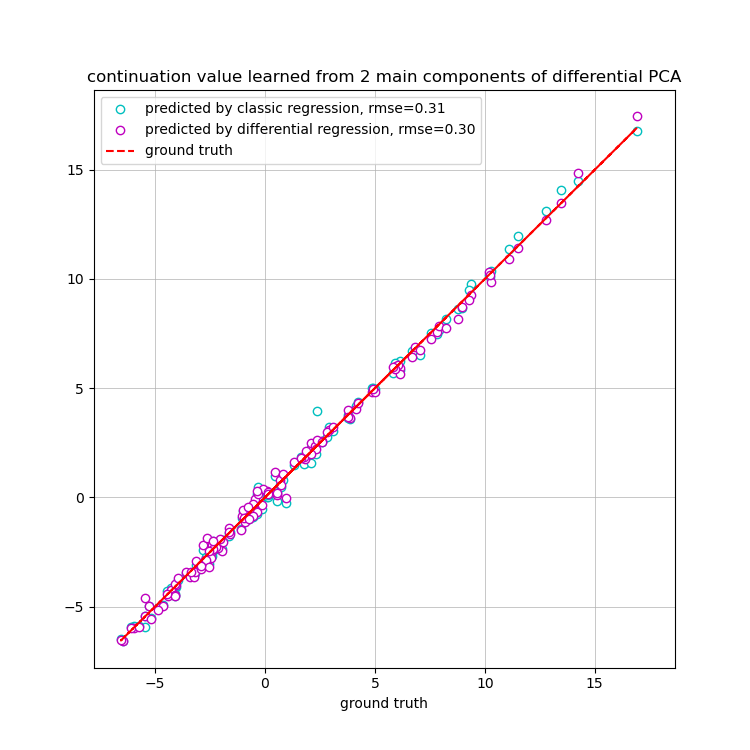

In [154]:
dim = 2

dpca = DiffPCA(dim)
x_reduced, z_reduced = dpca.fit_transform(x_train, z_train)
print(x_reduced.shape, z_reduced.shape)

test_reduced = dpca.transform(x_test)

classic_reg.fit(x_reduced, y_train)
classic_pred = classic_reg.predict(test_reduced)

diff_reg.fit(x_reduced, y_train, z_reduced)
diff_pred = diff_reg.predict(test_reduced)

correct = y_test

plt.figure(figsize=(7.5,7.5))
draw_test_results(plt.gca(), correct, [classic_pred, diff_pred], title="continuation value learned from 2 main components of differential PCA", 
                  colors=['c', 'm'], 
                  labels=['classic regression', 'differential regression'])
_ = plt.show()

Both classic and differential regression learn correct continuation values from reduced data. There is no much difference between the two with as much as 8,192 training examples in dimension two. Note that the reduction did not affect the accuracy of the learned continuation value. On the contrary, differential regression performs slightly better and classic regression performs a lot better in reduced dimension. ML algorithms and regression in particular work better in low dimension, as long as no meaningul information is truncated. It appears that differential PCA safely reduced dimension, without removing anything that could matter for the Bermudan option. 

Let us now visualize the risk factors identified by differential PCA, in forward rate space:

<IPython.core.display.Javascript object>


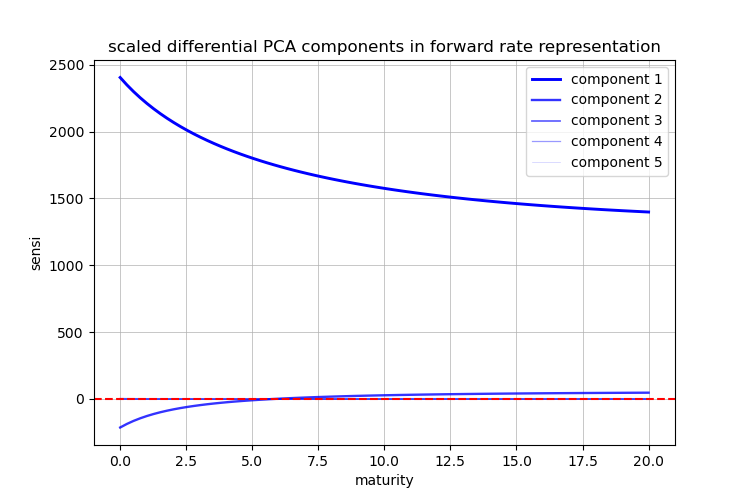

In [155]:
dpca = DiffPCA()
dpca.fit_transform(x_train, z_train)
scaled_components = dpca.components_ * np.sqrt(dpca.explained_variance_).reshape(-1, 1)

plt.figure(figsize=(7.5, 5))
n = scaled_components.shape[0]
draw_fwd_curves(plt.gca(), scaled_components, ['component %d' % (i+1) for i in range(n)], 
                "scaled differential PCA components in forward rate representation",
                colors=[[0,0,1,1-0.2*i] for i in range(n)],
                widths=[2-0.4*i+0.1 for i in range(n)],
               percent=False,
               ylabel="sensi")
_ = plt.show()

Contrarily to classic PCA, we observe that the 3th, 4th and 5th factors are also insignificant in forward rate representation. Contrarily to variation, relevance remains consistent with different representations (although, in principle, this is exactly true when performed on normalized data).

As expected, the main risk factor is a shift of the curve, non-parallel and mainly affecting the short to medium end, and the second, much less prononced risk factor, is a curve reversal around the second call date, distant by three years, and mainly affecting the short end.

What about reducing dimension further to dimension 1, which accounts for around 99% of the total relevance, and given the small (but not negligible) magnitude of the second component in the forward rate representation?

(8192, 1) (8192, 1)


<IPython.core.display.Javascript object>


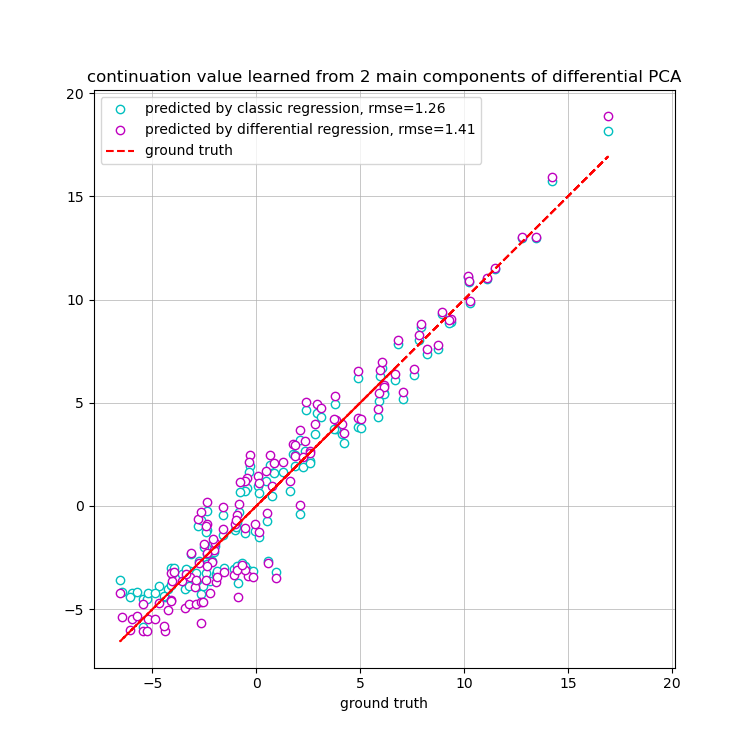

In [156]:
dim = 1

dpca = DiffPCA(dim)
x_reduced, z_reduced = dpca.fit_transform(x_train, z_train)
print(x_reduced.shape, z_reduced.shape)

test_reduced = dpca.transform(x_test)

classic_reg.fit(x_reduced, y_train)
classic_pred = classic_reg.predict(test_reduced)

diff_reg.fit(x_reduced, y_train, z_reduced)
diff_pred = diff_reg.predict(test_reduced)

correct = y_test

plt.figure(figsize=(7.5,7.5))
draw_test_results(plt.gca(), correct, [classic_pred, diff_pred], title="continuation value learned from 2 main components of differential PCA", 
                  colors=['c', 'm'], 
                  labels=['classic regression', 'differential regression'])
_ = plt.show()

We see that the continuation value is no longer correctly learned. The second risk factor may not be safely ignored. Bermudan options are fundamentally two-factor instruments, as derived by Andersen and Andreasen by analysis, and just verified from data with differential PCA. The factor dependence of any other Derivative instrument or trading book can be inferred from simulated data in an identical manner.

By contrast, European swaptions are one-factor instruments, only depending on the forward rate of the underlying swap, irrespective of the rest of the curve. We can immediately verify this from the European dataset.

<IPython.core.display.Javascript object>


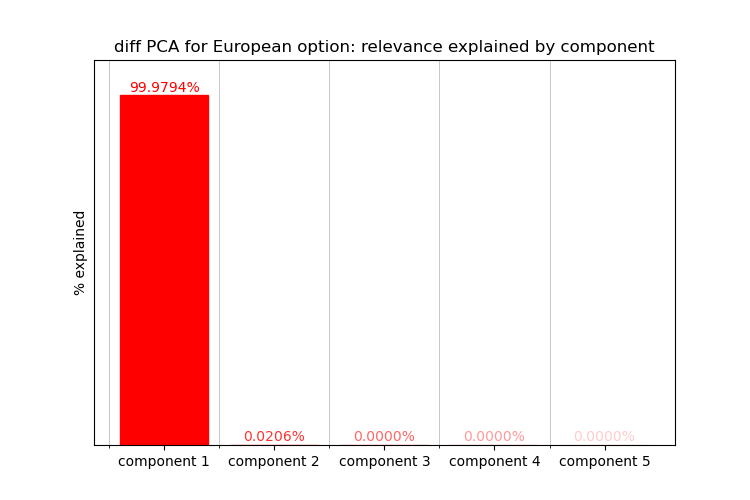

In [157]:
# fit
dpca = DiffPCA()
dpca.fit(x_train, z_train_euro)

# plot
plt.figure(figsize=(7.5,5))
draw_explained_variance(plt.gca(), dpca, "diff PCA for European option: relevance explained by component")
_ = plt.show()

<IPython.core.display.Javascript object>


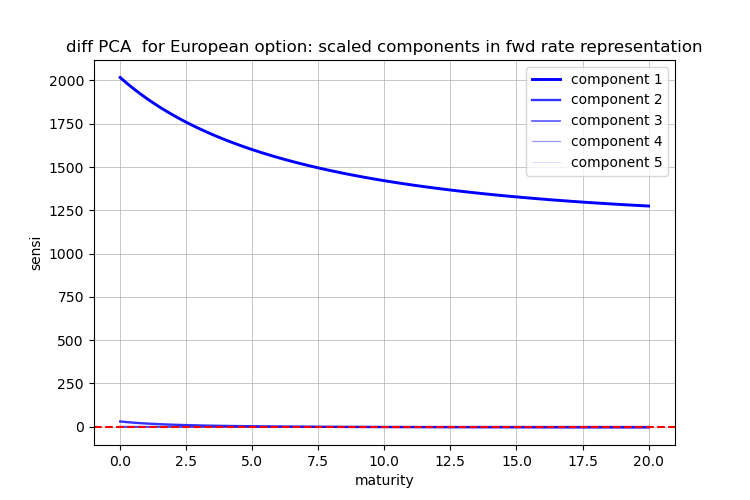

In [158]:
scaled_components = dpca.components_ * np.sqrt(dpca.explained_variance_).reshape(-1, 1)

plt.figure(figsize=(7.5, 5))
n = scaled_components.shape[0]
draw_fwd_curves(plt.gca(), scaled_components, ['component %d' % (i+1) for i in range(n)], 
                "diff PCA  for European option: scaled components in fwd rate representation",
                colors=[[0,0,1,1-0.2*i] for i in range(n)],
                widths=[2-0.4*i+0.1 for i in range(n)],
               percent=False,
               ylabel="sensi")
_ = plt.show()

With the European dataset, the first factor accounts for roughly 99.98% of the relevance, and appears as the only relevant factor, both in $X$ and forward rate representations. Note that the second factor is definitely negligible, but not exactly zero. This is because the data was generated with a pysically settled swaption, which is not exactly a one-factor instrument, contrarily to cash-settled swaptions (which also means that differential PCA can tell when a financial product is settled physically or in cash).  

We quickly verify that the European swaption value is accurately learned from reduced data in dimension one:

(8192, 1) (8192, 1)


<IPython.core.display.Javascript object>


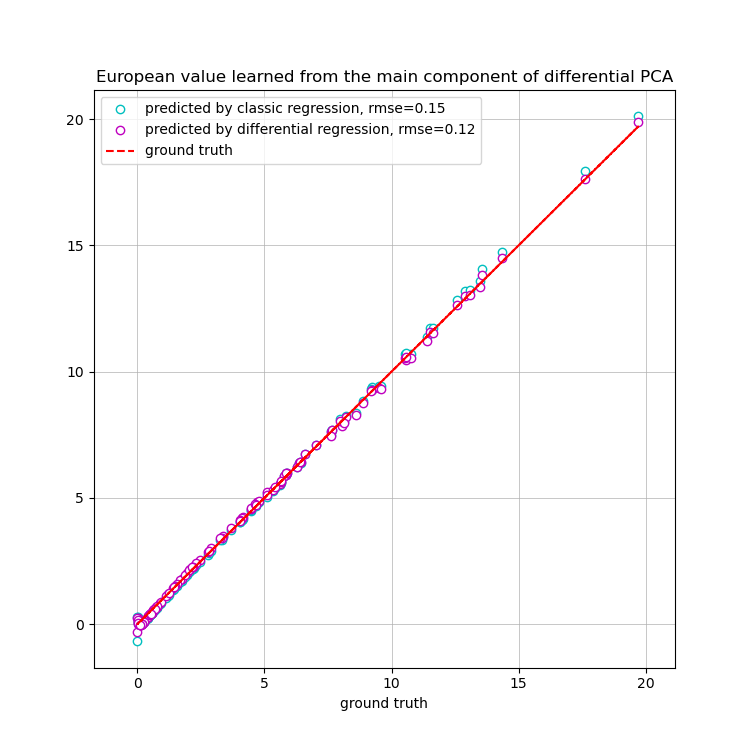

In [159]:
dim = 1

dpca = DiffPCA(dim)
x_reduced, z_reduced = dpca.fit_transform(x_train, z_train_euro)
print(x_reduced.shape, z_reduced.shape)

test_reduced = dpca.transform(x_test)

classic_reg.fit(x_reduced, y_train_euro)
classic_pred = classic_reg.predict(test_reduced)

diff_reg.fit(x_reduced, y_train_euro, z_reduced)
diff_pred = diff_reg.predict(test_reduced)

correct = y_test_euro

plt.figure(figsize=(7.5,7.5))
draw_test_results(plt.gca(), correct, [classic_pred, diff_pred], title="European value learned from the main component of differential PCA", 
                  colors=['c', 'm'], 
                  labels=['classic regression', 'differential regression'])
_ = plt.show()

In fact, the European swaption value is learned much better from reduced data than original data:

<IPython.core.display.Javascript object>


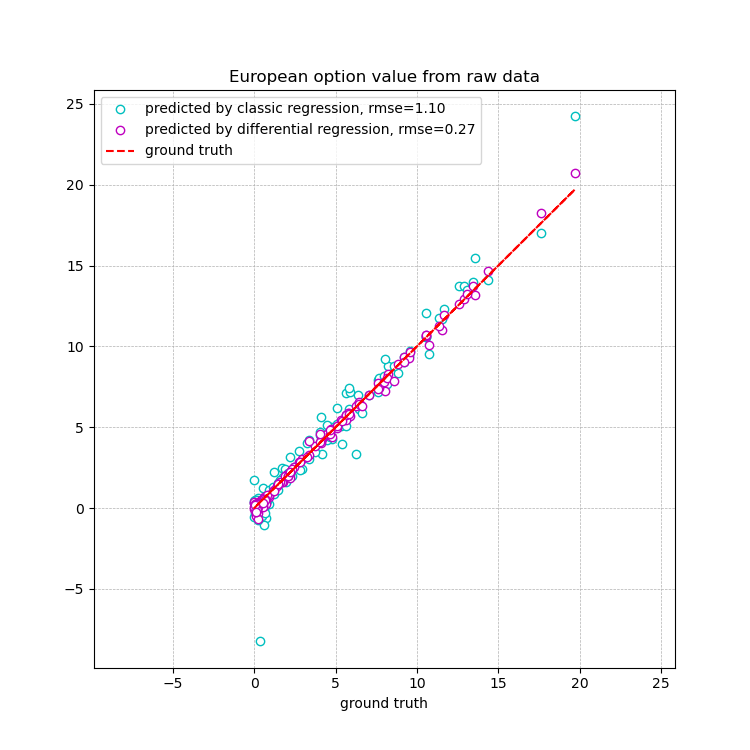

In [160]:
# regress original data and draw
plt.figure(figsize=(7.5, 7.5))

classic_reg.fit(x_train, y_train_euro)
pred = classic_reg.predict(x_test)
errors = pred - y_test_euro
rmse = np.sqrt(np.square(errors).mean())

plt.plot(y_test_euro, pred, 'co', markerfacecolor="white", label="predicted by classic regression, rmse=%.2f" % rmse)

diff_reg.fit(x_train, y_train_euro, z_train_euro)
pred = diff_reg.predict(x_test)
errors = pred - y_test_euro
rmse = np.sqrt(np.square(errors).mean())

plt.plot(y_test_euro, pred, 'mo', markerfacecolor="white", label="predicted by differential regression, rmse=%.2f" % rmse)

plt.plot(y_test_euro, y_test_euro, 'r--', label="ground truth")

plt.xlabel('ground truth')
plt.title("European option value from raw data")
plt.xlim(plt.ylim())
plt.legend()
plt.grid(ls='--', lw=0.5)
plt.show()

This conludes our exploration of the application of differential dimension reduction to real-world Derivatives problems. We clearly illustrated the danger of classic PCA for dimension reduction in the context of Derivatives pricing and risk, and the seamless performance of differential PCA, as demonstrated in the Risk article, along with its ability to correctly identify the factor dependence of Derivative instruments, reliably and automatically, from simulated data.

# Article graphs

This appendix reuses the code developed in the notebook to reproduce the graphs of the October 2021 Risk article.

In [161]:
# set image format
%matplotlib inline


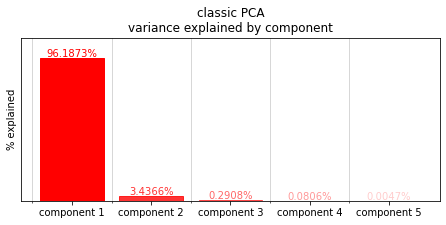

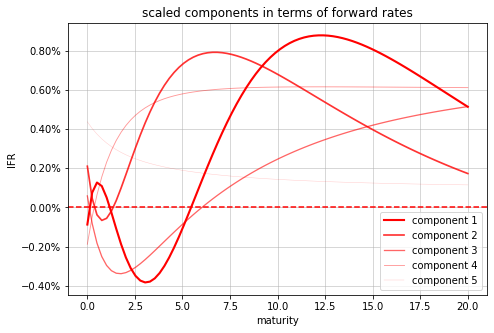

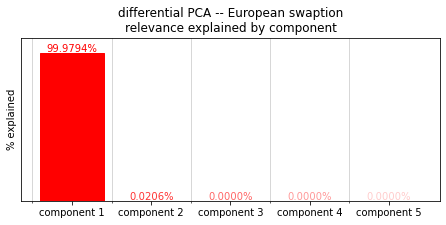

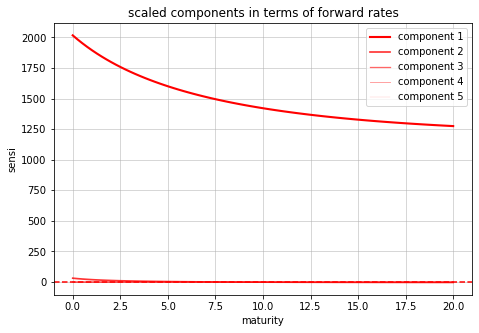

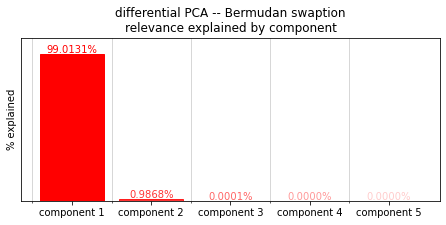

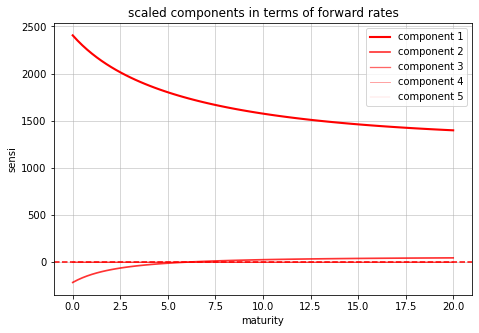

In [172]:
# scaled components and exlained variance / relevance with classic PCA, diff PCA for European option and diff PCA for Bermudan option

# classic PCA

# bermudan dataset
x, y, z, tx, ty = x_train, y_train, z_train, x_test, y_test

# classic PCA
pca = PCA()
pca.fit(x)

# explained variance
plt.figure(figsize=(7.5, 3))
draw_explained_variance(plt.gca(), pca, "classic PCA\nvariance explained by component")
_ = plt.show()

# scaled components in foward space
scaled_components = pca.components_ * np.sqrt(pca.explained_variance_).reshape(-1, 1)
plt.figure(figsize=(7.5, 5))
n = scaled_components.shape[0]
draw_fwd_curves(plt.gca(), scaled_components, ['component %d' % (i+1) for i in range(n)], 
                "scaled components in terms of forward rates",
                colors=[[1,0,0,1-0.2*i] for i in range(n)],
                widths=[2-0.4*i+0.1 for i in range(n)])
_ = plt.show()

# differential PCA - European option

# european dataset
x, y, z, tx, ty = x_train, y_train_euro, z_train_euro, x_test, y_test_euro

# differential PCA 
pca = DiffPCA()
pca.fit(x, z)

# explained variance
plt.figure(figsize=(7.5, 3))
draw_explained_variance(plt.gca(), pca, "differential PCA -- European swaption\nrelevance explained by component")
_ = plt.show()

# scaled components in foward space
scaled_components = pca.components_ * np.sqrt(pca.explained_variance_).reshape(-1, 1)
plt.figure(figsize=(7.5, 5))
n = scaled_components.shape[0]
draw_fwd_curves(plt.gca(), scaled_components, ['component %d' % (i+1) for i in range(n)], 
                "scaled components in terms of forward rates",
                colors=[[1,0,0,1-0.2*i] for i in range(n)],
                widths=[2-0.4*i+0.1 for i in range(n)],
               percent=False,
               ylabel="sensi")
_ = plt.show()

# differential PCA - Bermudan option

# bermudan dataset
x, y, z, tx, ty = x_train, y_train, z_train, x_test, y_test

# differential PCA 
pca = DiffPCA()
pca.fit(x, z)

# explained variance
plt.figure(figsize=(7.5, 3))
draw_explained_variance(plt.gca(), pca, "differential PCA -- Bermudan swaption\nrelevance explained by component")
_ = plt.show()

# scaled components in foward space
scaled_components = pca.components_ * np.sqrt(pca.explained_variance_).reshape(-1, 1)
plt.figure(figsize=(7.5, 5))
n = scaled_components.shape[0]
draw_fwd_curves(plt.gca(), scaled_components, ['component %d' % (i+1) for i in range(n)], 
                "scaled components in terms of forward rates",
                colors=[[1,0,0,1-0.2*i] for i in range(n)],
                widths=[2-0.4*i+0.1 for i in range(n)],
               percent=False,
               ylabel="sensi")
_ = plt.show()

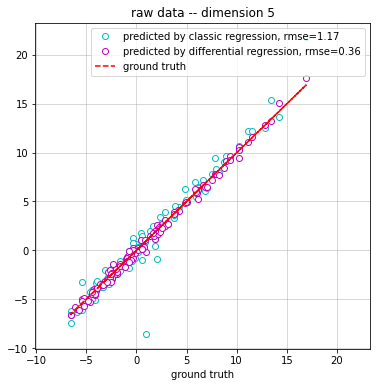

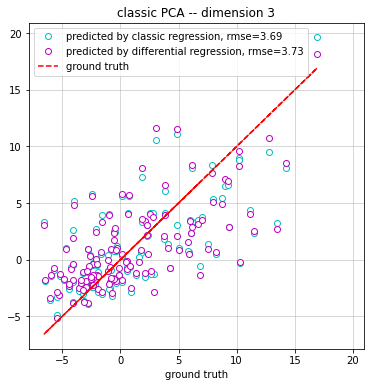

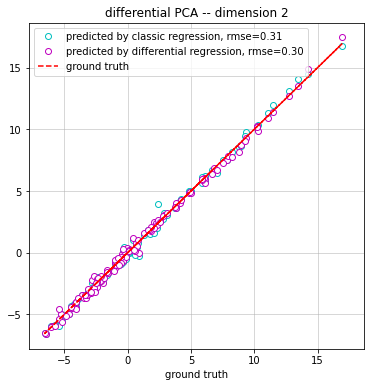

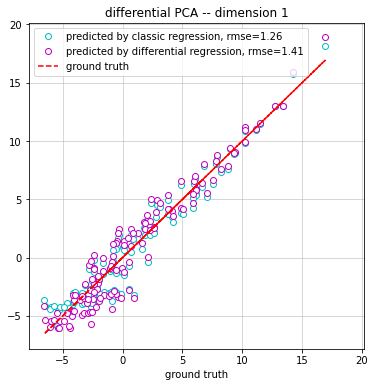

In [171]:
# regression quality

# original data

x, y, z, tx, ty = x_train, y_train, z_train, x_test, y_test

# classic regression
classic_reg = make_polynomial()
classic_reg.fit(x, y)
classic_pred = classic_reg.predict(tx)
# differential regression
diff_reg = DifferentialRegression()
diff_reg.fit(x, y, z)
diff_pred = diff_reg.predict(tx)
# ground truth
correct = ty

plt.figure(figsize=(6, 6))
draw_test_results(plt.gca(), correct, [classic_pred, diff_pred], title="raw data -- dimension 5", 
                  colors=['c', 'm'], 
                  labels=['classic regression', 'differential regression'])
_ = plt.show()

# classic pca, dimension 3

dim = 3
pca = PCA(dim)
x = pca.fit_transform(x_train)
z = pca.transform(z_train) # z_reduced = d y / d x_reduced
tx = pca.transform(x_test)

# classic regression
classic_reg = make_polynomial()
classic_reg.fit(x, y)
classic_pred = classic_reg.predict(tx)
# differential regression
diff_reg = DifferentialRegression()
diff_reg.fit(x, y, z)
diff_pred = diff_reg.predict(tx)

plt.figure(figsize=(6, 6))
draw_test_results(plt.gca(), correct, [classic_pred, diff_pred], title="classic PCA -- dimension 3", 
                  colors=['c', 'm'], 
                  labels=['classic regression', 'differential regression'])
_ = plt.show()

# differential pca, dimension 2

dim = 2
pca = DiffPCA(dim)
x, z = pca.fit_transform(x_train, z_train)
tx = pca.transform(x_test)

# classic regression
classic_reg = make_polynomial()
classic_reg.fit(x, y)
classic_pred = classic_reg.predict(tx)
# differential regression
diff_reg = DifferentialRegression()
diff_reg.fit(x, y, z)
diff_pred = diff_reg.predict(tx)

plt.figure(figsize=(6, 6))
draw_test_results(plt.gca(), correct, [classic_pred, diff_pred], title="differential PCA -- dimension 2", 
                  colors=['c', 'm'], 
                  labels=['classic regression', 'differential regression'])
_ = plt.show()


test_reduced = dpca.transform(x_test)

# differential pca, dimension 1

dim = 1
pca = DiffPCA(dim)
x, z = pca.fit_transform(x_train, z_train)
tx = pca.transform(x_test)

# classic regression
classic_reg = make_polynomial()
classic_reg.fit(x, y)
classic_pred = classic_reg.predict(tx)
# differential regression
diff_reg = DifferentialRegression()
diff_reg.fit(x, y, z)
diff_pred = diff_reg.predict(tx)

plt.figure(figsize=(6, 6))
draw_test_results(plt.gca(), correct, [classic_pred, diff_pred], title="differential PCA -- dimension 1", 
                  colors=['c', 'm'], 
                  labels=['classic regression', 'differential regression'])
_ = plt.show()


test_reduced = dpca.transform(x_test)

In [ ]:
# reset image format
if colab:
  %matplotlib inline
else:
  %matplotlib notebook